In [1]:
import sys
sys.path.append("..")

import tensorflow as tf

from utils import data_utils, preprocess_data, tf_config, train, losses_utils, lrp, viz_utils, fmri_utils

from layers import topographical_attention

from models import classifiers, eeg_to_fmri

memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=3)#02 20
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit, run_eagerly=True)

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import pickle

dataset="10"
dataset_synthesis="01"
raw_eeg=False

if(dataset=="10"):
    n_individuals=43
elif(dataset=="11"):
    n_individuals=31
    

with tf.device('/CPU:0'):    
    dataset_clf_wrapper = preprocess_data.Dataset_CLF_CV(dataset, standardize_eeg=True, eeg_limit=True, eeg_f_limit=135, load=True)
    train_data, test_data = dataset_clf_wrapper.split(0)
    dataset_clf_wrapper.X = train_data[0]
    dataset_clf_wrapper.y = train_data[1]
    dataset_clf_wrapper.shuffle()
    #dataset_clf_wrapper.set_folds(5)
    train_data, test_data = dataset_clf_wrapper.split(0)
    X_train, y_train=train_data
    X_test, y_test=test_data

2022-10-03 10:13:03.851997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-03 10:13:06.040962: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-03 10:13:06.041460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-03 10:13:06.082403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 10:13:06.082867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-10-03 10:13:06.082893: I tensorflow/stream_executor/platform/def

/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../utils/eeg_utils.py:199: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True, verbose=0)
/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../utils/eeg_utils.py:199: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True, verbose=0)
/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../utils/eeg_utils.py:199: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True, verbose=0)
/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../util

/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../utils/eeg_utils.py:199: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2', 'EXG3', 'EXG4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True, verbose=0)
/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../utils/eeg_utils.py:199: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2', 'EXG3', 'EXG4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True, verbose=0)
/home/ist_davidcalhas/eeg_to_fmri/src/notebooks/../utils/eeg_utils.py:199: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2', 'EXG3', 'EXG4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True, verbose=0)
/home/i

(8729, 132, 134)
(860, 132, 134, 10)


## Pretrain synthesis neural network

In [2]:
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/padded"
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/variational"
network="/home/ist_davidcalhas/eeg_to_fmri/networks/deterministic"
#network="/home/ist_davidcalhas/eeg_to_fmri/networks/bayesian"

optimizer = tf.keras.optimizers.Adam(1e-3)
activation=tf.keras.activations.linear
variational=True
regularization=False
if(regularization):
    network+="_reg"
train_set = tf.data.Dataset.from_tensor_slices((X_test, y_test[:,1])).batch(8)
#train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test[:,1])).batch(1)

#loss_fn=losses_utils.nll_loss
siamese_projection=False
siamese_projection_dimension=10
clf_EEG=True
#linearCLF=classifiers.ViewClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], latent_clf=clf_EEG, activation=activation, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False, variational=variational)
#linearCLF=classifiers.ViewContrastiveClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], dimension, latent_clf=clf_EEG, activation=activation, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False, variational=variational)
#linearCLF=classifiers.Contrastive(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], dimension, latent_clf=clf_EEG, activation=activation, regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0), feature_selection=False, segmentation_mask=False, variational=variational)
linearCLF=classifiers.ViewLatentContrastiveClassifier(tf.keras.models.load_model(network,custom_objects=eeg_to_fmri.custom_objects), X_train.shape[1:], activation=activation, regularizer=tf.keras.regularizers.L1(l=2.), feature_selection=False, segmentation_mask=False, siamese_projection=siamese_projection, siamese_projection_dimension=siamese_projection_dimension, variational=variational)

loss_fn=losses_utils.ContrastiveClassificationLoss(m=np.pi, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
#loss_fn=losses_utils.ContrastiveLoss(m=np.pi, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
train_set=preprocess_data.DatasetContrastive(X_train, y_train, pairs=1, batch=8, clf=True)
#train_set.pairs=1

linearCLF.build(X_train.shape)

train.train(train_set, linearCLF, optimizer, loss_fn, epochs=10, val_set=None, u_architecture=False, verbose=True, verbose_batch=True)

2022-10-03 10:16:32.910738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-03 10:16:33.239587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-10-03 10:16:33.241785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-10-03 10:16:34.061923: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-10-03 10:16:34.109217: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1 with loss: 12.736214834509545
Epoch 2 with loss: 7.288845812232749
Epoch 3 with loss: 3.9465000993997146
Epoch 4 with loss: 3.032829142311244
Epoch 5 with loss: 4.324455120320459
Epoch 6 with loss: 4.178640408278669
Epoch 7 with loss: 2.9199406588540495
Epoch 8 with loss: 4.573033893426645
Epoch 9 with loss: 1.9738091238349387
Epoch 10 with loss: 1.7428734554249106


([12.736214834509545,
  7.288845812232749,
  3.9465000993997146,
  3.032829142311244,
  4.324455120320459,
  4.178640408278669,
  2.9199406588540495,
  4.573033893426645,
  1.9738091238349387,
  1.7428734554249106],
 [],
 [],
 [],
 [])

In [3]:
for x,y in test_set.repeat(1):
    
    print(linearCLF.view.eeg_encoder(x).numpy()[0,0], tf.cos(linearCLF.view.eeg_encoder(x).numpy()[0,0]).numpy(), linearCLF.view.q_decoder(x)[0,30,30,15,0].numpy(), y.numpy())
    print(np.mean(linearCLF.view.eeg_encoder(x)), np.std(linearCLF.view.eeg_encoder(x)))

0.37867272 0.9291561 0.3784004 [1.]
1.5707964 1.5707904
3.537188 -0.9227673 0.24763332 [0.]
1.5707964 1.5706427
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
3.0815105 -0.9981956 0.29145488 [1.]
1.5707965 1.5702645
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
0.38723958 0.925955 0.40389732 [0.]
1.5707965 1.5707914
3.49115 -0.9395244 0.21767262 [0.]
1.5707964 1.5706098
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
1.765493 -0.19346899 0.3636654 [0.]
1.5707964 1.5704937
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
3.5035496 -0.93520564 0.20995623 [0.]
1.5707964 1.5705905
0.2678442 0.96434367 0.40808892 [1.]
1.5707964 1.5707959
3.4759398 -0.9446248 0.25293493 [0.]
1.5707964 1.570649
0.7575738 0.7265054 0.4047818 [1.]
1.5707965 1.5707604
0.25477886 0.9677191 0.40899518 [1.]
1.5707964 1.5707963
3.5075772 -0.9337719 0.20257208 [

In [4]:
from utils import process_utils

process_utils.predict(test_set, linearCLF)

(array([1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1.]),
 array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1.]),
 array([1.00000000e+00, 8.45593987e-29, 4.00730716e-36, 8.14510286e-01,
        1.20188914e-31, 3.56913701e-37, 1.00000000e+00, 2.09329213e-32,
        3.22367910e-25, 1.37349715e-37, 9.99998689e-01, 5.83927101e-31,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.99766648e-01,
        1.00000000e+00, 2.01830355e-26, 3.29282863e-20, 9.90469277e-01]))

In [5]:
hits = np.empty((0,))
y_true = np.empty((0,))
y_pred = np.empty((0,))

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train[:,1])).batch(1)
T=100

variational=True

for x,y in test_set.repeat(1):
    if(y.numpy()[0]==1.0):
        y_true=np.append(y_true,1.0)
    else:
        y_true=np.append(y_true,0.0)
        
    if("variational" in network or "bayesian" in network or variational):
        y_hat=linearCLF(x).numpy()[0,0]
        for i in range(T-1):
            y_hat+=linearCLF(x).numpy()[0,0]
        y_hat/=T
    else:
        y_hat=linearCLF(x).numpy()[0,0]
        
    y_pred=np.append(y_pred, y_hat)
    print(y_hat, (y[0]==1.0).numpy().astype(np.int64))
    if(tf.math.reduce_all(tf.math.equal(tf.cast(y==1.0,tf.int64), tf.cast(y_hat>=0.5, tf.int64)).numpy())):
        hits = np.append(hits, 1.0)
    else:
        hits = np.append(hits, 0.0)
    
tp = len(y_pred[np.where(y_pred[np.where(y_true==1.0)] >= 0.5)])
fn = len(y_pred[np.where(y_pred[np.where(y_true==1.0)] < 0.5)])

tn = len(y_pred[np.where(y_pred[np.where(y_true==0.0)] < 0.5)])
fp = len(y_pred[np.where(y_pred[np.where(y_true==0.0)] >= 0.5)])

print(hits)
print("Acc:", np.mean(hits), "\pm", np.std(hits))
print("Sens:", tp/(tp+fn))
print("Spe:", tn/(tn+fp))

29.9224951171875 1
-77.22826171875 0
-71.0266064453125 0
-2.7575723266601564 1
-73.89546875 0
-76.3408251953125 0
25.262607421875 0
-74.8486962890625 0
-72.089013671875 0
-71.434111328125 0
-12.733045654296875 0
-76.649091796875 0
-70.966337890625 0
32.0487548828125 1
-76.9048388671875 0
9.8472216796875 1
30.843271484375 1
-70.4952783203125 0
-74.2267529296875 0
19.9744775390625 1
[1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Acc: 0.9 \pm 0.30000000000000004
Sens: 0.8333333333333334
Spe: 0.9285714285714286


In [6]:
from sklearn.metrics import roc_auc_score

y_true = np.empty((0,1), dtype=np.float32)
y_pred = np.empty((0,1), dtype=np.float32)

linearCLF.training=False

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train[:,1])).batch(1)

for x,y in test_set.repeat(1):
    
    y_true=np.append(y_true, np.expand_dims(y,axis=0), axis=0)
    
    if("variational" in network or "bayesian" in network or variational):
        y_hat=tf.nn.sigmoid(linearCLF(x)).numpy()[:,:]
        for i in range(T-1):
            y_hat=np.append(y_hat,tf.nn.sigmoid(linearCLF(x)).numpy()[:,:],axis=0)
        y_hat=np.expand_dims(np.mean(y_hat, axis=0), axis=0)
    else:
        y_hat=tf.nn.sigmoid(linearCLF(x)).numpy()[0,0]
        
        
    y_pred=np.append(y_pred, y_hat, axis=0)

roc_auc_score(y_true, y_pred, multi_class='ovr', average="samples")

0.9642857142857143

## Synthesized EEG views set

In [7]:
from utils import fmri_utils
train_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_"+dataset_synthesis)+(1,))

for x, _ in test_set.repeat(1):
    train_views = np.append(train_views, linearCLF.view.q_decoder(x), axis=0)
    
dev_views_set = tf.data.Dataset.from_tensor_slices((train_views,y_test[:,1])).batch(1)

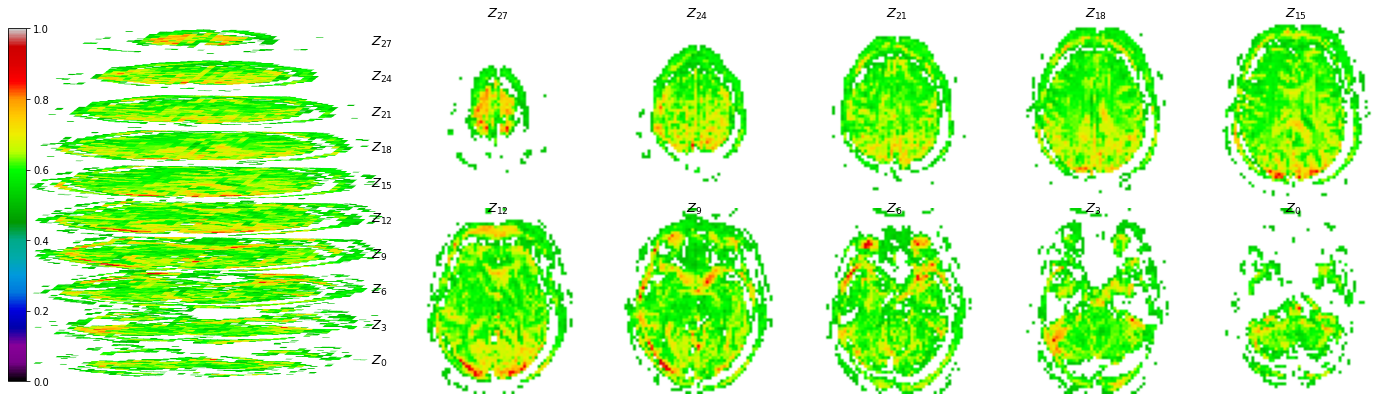

In [8]:
for x, _ in dev_views_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(x.numpy()[0,:,:,:,:],
                                                        slice_label=True,
                                                        uncertainty=False,
                                                        threshold=0.50,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,)# save_path=path+"/explainability/fmri_E_R.pdf",
    break

## Explaining prediction

In [9]:
for x, y in dev_views_set.repeat(1):
    
    print(linearCLF.clf(x).shape)
    break

(1, 1)


In [10]:
explainer = lrp.LRP(linearCLF.clf)
R=lrp.explain(explainer, dev_views_set, verbose=True)

In [11]:
dev_R_views_set = tf.data.Dataset.from_tensor_slices((R,y_test[:,1])).batch(1)

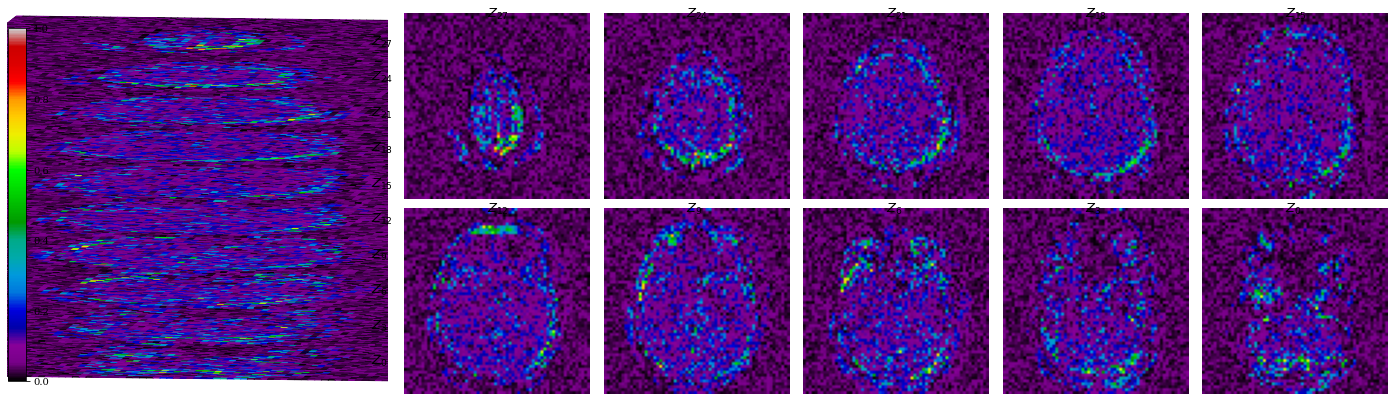

In [12]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(np.abs(R), axis=0),
                                                        #res_img=np.mean(np.abs(R), axis=0),
                                                        slice_label=False,
                                                        uncertainty=False,
                                                        #cmap=plt.cm.gist_heat,
                                                        threshold=0.0,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,# save_path=path+"/explainability/fmri_E_R.pdf",
                                                       max_min_legend=["Negative","Positive"])

In [13]:
explainer = lrp.LRP_EEG(linearCLF.view)
attention_scores=lrp.explain(explainer, dev_set, eeg=True, eeg_attention=True, fmri=False, verbose=True)

AssertionError: 

In [ ]:
viz_utils.plot_attention_eeg(np.mean(attention_scores, axis=0),
                            dataset=dataset,
                            plot_names=True,
                            edge_threshold=np.percentile(attention_scores, 98.5))